# Evaluation

# Coverage / Time

In [319]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [320]:
resultspath = '../results/'
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [322]:
def convert_unixtime_deltaseconds(df, timecolumn='# unix_time'):
    df['date'] = pd.to_datetime(df[timecolumn],unit='s')
    return df

#https://stackoverflow.com/questions/25234941/python-regularise-irregular-time-series-with-linear-interpolation
def resample_timeseries(df, resample_freq, resample_col, time_series_col='date'):
    df_ = df[[time_series_col, resample_col]]
    df_ = df_.append({time_series_col: df_['date'].iloc[0] + pd.Timedelta(hours=24)}, ignore_index=True)
    df_[resample_col] = df_[resample_col].ffill()
    
    df_ = df_.set_index(time_series_col).resample('s').interpolate().resample(resample_freq).asfreq().fillna(0)
    df_ = df_.reset_index()
    df_['delta_time'] = df_['date']-df_['date'].iloc[0]
    return df_

def utest(dffinal, x_var='delta_time', y_var='cur_path', event1='AFL', event2='Curious_AFL'):
    dffinal2 = dffinal.groupby([x_var, 'event']).mean().reset_index()
    dffinal2_afl = dffinal2.loc[dffinal2['event']==event1][y_var]
    dffinal2_curious = dffinal2.loc[dffinal2['event']==event2][y_var]
    stat, p = mannwhitneyu(dffinal2_afl, dffinal2_curious)
    return np.round(p, 6)

In [323]:
def df_plotdata_resample(df, event, field, rename_field):
    df = convert_unixtime_deltaseconds(df)
    df_ = resample_timeseries(df, '5T', field)
    
    #df = df[['delta_time', field]]
    df_ = df_.rename(columns={field: rename_field})
    #df_ = pd.concat([pd.DataFrame({'date': df['date'].iloc[0], rename_field: 0}), df_]).reset_index() 
    #df[rename_field] =df[rename_field].ffill()
    df_['event'] = event
    return df_

def df_coverage_resample(df, event):
    df = convert_unixtime_deltaseconds(df, timecolumn='m_timestamp')
    df = df[['total_coverage', 'delta_time']]
    df = resample_timeseries(df, '5T', time_series_col='delta_time')

    df = df[['delta_time', 'total_coverage']]
    df = df.rename(columns={'total_coverage': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    
    df['event'] = event
    return df

## path-coverages

In [330]:
results = {
    'objdump': pd.DataFrame(),
    'nm': pd.DataFrame(),
    'ffmpeg': pd.DataFrame()
}
empty_seed = False

In [331]:
if empty_seed:
    seed=''
else:
    seed='pre'
    
for exec_name in results:
    try:    
        for trial in range(1,11):
            #afl
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'afl' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFL', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)

            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'aflfast' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFLFast', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    
        for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'curious' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'CuriousAFL', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        continue
        
for exec_name in results:
    results[exec_name]['delta_time'] = results[exec_name]['delta_time'].dt.total_seconds() / 3600
#p = utest(dffinal)

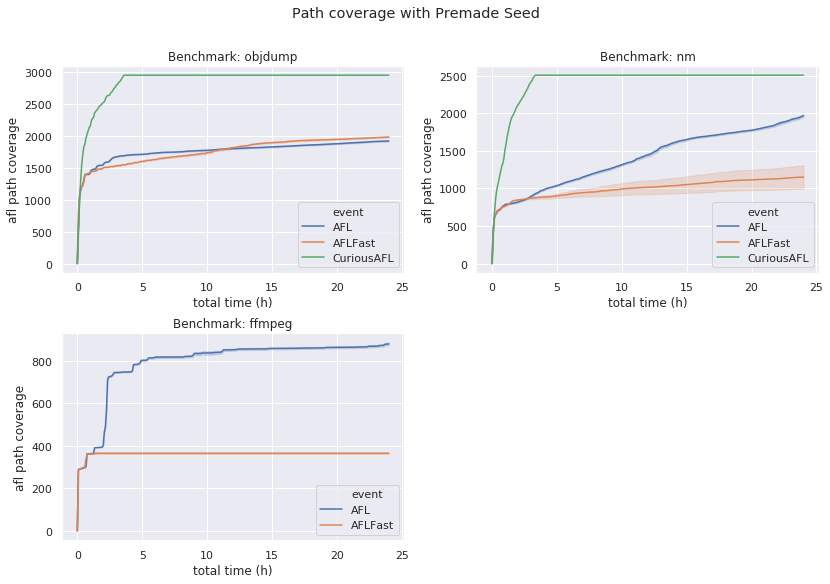

In [332]:
if empty_seed:
    seed='empty_seed'
else:
    seed='premade_seed'
#names = list(results.keys())
#fig, axes =plt.subplots(1,2) #sharey='row' for y-axis sharing
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)


ax1 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60,ax=ax1, data=results['objdump'])
ax1.set(xlabel='total time (h)', ylabel='afl path coverage')
ax1.legend()
ax1.title.set_text('Benchmark: ' + 'objdump')
#ax1.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

ax2 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax2, data=results['nm'])
ax2.set(xlabel='total time (h)', ylabel='afl path coverage')
ax2.legend()
ax2.title.set_text('Benchmark: ' + 'nm')

ax3 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax3, data=results['ffmpeg'])
ax3.set(xlabel='total time (h)', ylabel='afl path coverage')
ax3.legend()
ax3.title.set_text('Benchmark: ' + 'ffmpeg')

#plt.ylabel("afl path coverage")
if empty_seed:
    fig.suptitle('Path coverage with Empty Seed')
else:
    fig.suptitle('Path coverage with Premade Seed')
    
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig('./benchmarks_24h_path_coverage_'+ seed + '.png', dpi = 200)
#ax2.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

## Unique-crashes

In [336]:
results = {
    'objdump': pd.DataFrame(),
    'nm': pd.DataFrame(),
    'ffmpeg': pd.DataFrame()
}
empty_seed = False

In [337]:
if empty_seed:
    seed=''
else:
    seed='pre'
    
for exec_name in results:
    try:
        for trial in range(1,11):
            #afl
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'afl' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFL', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)

            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'aflfast' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFLFast', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)

    
        for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'curious' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'CuriousAFL', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)
    except:
        continue
        
for exec_name in results:
    results[exec_name]['delta_time'] = results[exec_name]['delta_time'].dt.total_seconds() / 3600
#p = utest(dffinal)

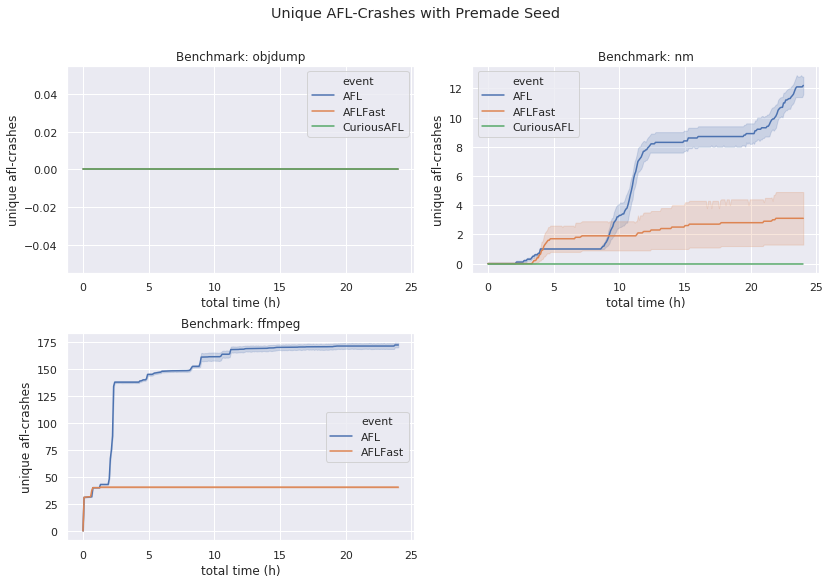

In [338]:
if empty_seed:
    seed='empty_seed'
else:
    seed='premade_seed'
#names = list(results.keys())
#fig, axes =plt.subplots(1,2) #sharey='row' for y-axis sharing
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)


ax1 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60,ax=ax1, data=results['objdump'])
ax1.set(xlabel='total time (h)', ylabel='unique afl-crashes')
ax1.legend()
ax1.title.set_text('Benchmark: ' + 'objdump')
#ax1.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

ax2 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, ax=ax2, data=results['nm'])
ax2.set(xlabel='total time (h)', ylabel='unique afl-crashes')
ax2.legend()
ax2.title.set_text('Benchmark: ' + 'nm')

ax3 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, ax=ax3, data=results['ffmpeg'])
ax3.set(xlabel='total time (h)', ylabel='unique afl-crashes')
ax3.legend()
ax3.title.set_text('Benchmark: ' + 'ffmpeg')

#plt.ylabel("afl path coverage")
#plt.ylabel("afl path coverage")
if empty_seed:
    fig.suptitle('Unique AFL-Crashes with Empty Seed')
else:
    fig.suptitle('Unique AFL-Crashes with Premade Seed')
    
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig('./benchmarks_24h_unique_crashes_'+ seed + '.png', dpi = 200)
#ax2.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

## true coverage - BB coverage

In [146]:
results = {
    'objdump': pd.DataFrame(),
    #'nm': pd.DataFrame(),
    #'ffmpeg': pd.DataFrame()
}
empty_seed = True

In [147]:
for exec_name in results:
    for trial in range(1,8):
        resultpath = os.path.join('./' + exec_name + '_afl' + str(trial)+ '_empty.csv')
        df = pd.read_csv(resultpath)
        df = df_coverage_resample(df, 'AFL')
        df = df.loc[df['delta_time']<'24:00:00']
        results[exec_name] = results[exec_name].append(df)

        resultpath = os.path.join('./' + exec_name + '_aflfast' + str(trial)+ '_empty.csv')
        df = pd.read_csv(resultpath)
        df = df_coverage_resample(df, 'AFLFast')
        df = df.loc[df['delta_time']<'24:00:00']

        results[exec_name] = results[exec_name].append(df)
        
    
    try:
        for trial in ['']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'curious' + str(trial))
            df = pd.read_csv(resultpath)
            #df = df_plotdata_resample(df, 'CuriousAFL', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)
    except:
        continue

In [189]:
# aflfast
for trial in range(1,8):
    resultpath = os.path.join('./' + exec_name + '_aflfast' + str(trial)+ '_empty.csv')
    df = pd.read_csv(resultpath)
    
    df = convert_unixtime_deltaseconds(df, timecolumn='m_timestamp')
    df = df[['total_coverage', 'delta_time']]
    df = resample_timeseries(df, '5T', time_series_col='delta_time')


    df = df[['delta_time', 'total_coverage']]
    df = df.rename(columns={'total_coverage': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    
    df['event'] = "AFLFast"
    dffinal = dffinal.append(df)

In [190]:
# curious
for trial in ['']:
    resultpath = os.path.join('./' + exec_name + '_curious' + str(trial)+ '_empty.csv')
    df = pd.read_csv(resultpath)
    
    df = convert_unixtime_deltaseconds(df, timecolumn='m_timestamp')
    df = df[['total_coverage', 'delta_time']]
    df = resample_timeseries(df, '5T', time_series_col='delta_time')


    df = df[['delta_time', 'total_coverage']]
    df = df.rename(columns={'total_coverage': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    
    df['event'] = "Curious_AFL"
    dffinal = dffinal.append(df)

In [130]:
# neuzz
resultpath = os.path.join('./objdump_neuzz_empty.csv')
df = pd.read_csv(resultpath)

df = convert_unixtime_deltaseconds(df, timecolumn='m_timestamp')
df = df[['total_coverage', 'delta_time']]
df = resample_timeseries(df, '5T', time_series_col='delta_time')

df = df[['delta_time', 'total_coverage']]
df = df.rename(columns={'total_coverage': 'cur_path'})
df['cur_path'] =df['cur_path'].ffill()

df['event'] = "NEUZZ"
dffinal = dffinal.append(df)

In [140]:
dffinal = dffinal.loc[dffinal['delta_time']<'24:00:00']

TypeError: '<' not supported between instances of 'float' and 'str'

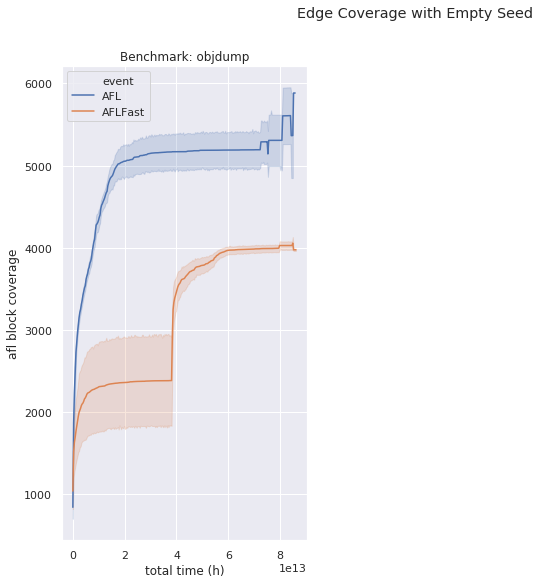

In [148]:
if empty_seed:
    seed='empty_seed'
else:
    seed='premade_seed'
#names = list(results.keys())
#fig, axes =plt.subplots(1,2) #sharey='row' for y-axis sharing
fig = plt.figure()
ax1 = fig.add_subplot(131)
#ax2 = fig.add_subplot(132)
#ax3 = fig.add_subplot(133)


ax1 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60,ax=ax1, data=results['objdump'])
ax1.set(xlabel='total time (h)', ylabel='afl block coverage')
ax1.legend()
ax1.title.set_text('Benchmark: ' + 'objdump')
#ax1.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

#ax2 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, ax=ax2, data=results['nm'])
#ax2.set(xlabel='total time (h)', ylabel='afl path coverage')
#ax2.legend()
#ax2.title.set_text('Benchmark: ' + 'nm')

#ax3 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, ax=ax3, data=results['ffmpeg'])
#ax3.set(xlabel='total time (h)', ylabel='afl path coverage')
#ax3.legend()
#ax3.title.set_text('Benchmark: ' + 'ffmpeg')

#plt.ylabel("afl path coverage")
fig.suptitle('Edge Coverage with Empty Seed')
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig('./'+seed+'_edge_coverage_24h.png', dpi = 200)
#ax2.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

TypeError: 'values' is not ordered, please explicitly specify the categories order by passing in a categories argument.

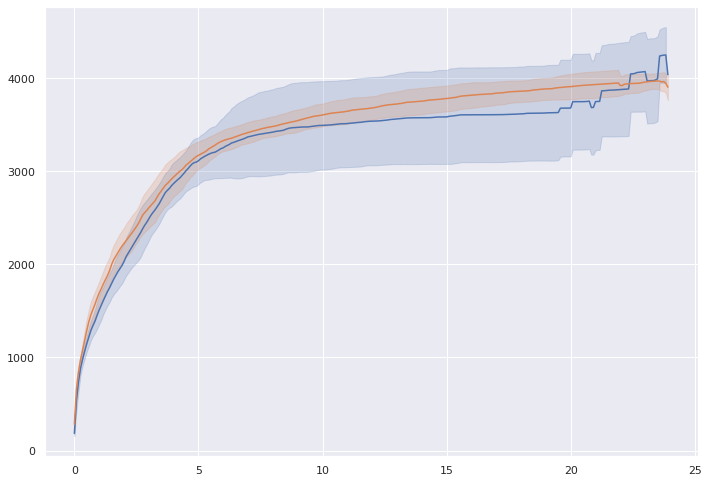

In [132]:
ax = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci="sd", data=dffinal)
ax.set(xlabel='total time (h)', ylabel='afl block coverage')

plt.legend()
plt.title('Benchmark: ' + exec_name)
#plt.text(3+0.2, 4.5, "AFLvsCuriousAFL p=" + str(p), horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./'+exec_name+'_BBcoverage_24h.png', dpi = 200)

# Coverage / Executions

## objdump

In [153]:
exec_name = 'objdump'
dffinal = pd.DataFrame()

In [154]:
for trial in ['1','2','3']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_afl' + str(trial))
    df = pd.read_csv(resultpath)
    df_helper = pd.DataFrame(np.array(range(df['# unix_time'][0], df['# unix_time'][len(df)-1]+1)))
    df_helper = df_helper.merge(df[['# unix_time', ' execs_per_sec', ' paths_total']], left_on=0, right_on='# unix_time', how='left', left_index=True)
    df_helper.set_index(0, inplace=True)
    del df_helper['# unix_time']
    df_helper[' execs_per_sec'].ffill(inplace=True)
    df_helper['running_exec_sum'] = df_helper[' execs_per_sec'].cumsum()
    df_helper = df_helper[[' paths_total', 'running_exec_sum']]
    
    df_helper['running_exec_sum'] = pd.to_datetime(df_helper['running_exec_sum'], unit='s', origin='unix')
    df = df_helper.set_index('running_exec_sum').resample('100000s').mean().reset_index()
    df['running_exec_sum'] = df.running_exec_sum.astype(int) / 10**9
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    #df = df.rename(columns={' paths_total': 'cur_path'})
    #del df['running_exec_sum']
    df['event'] = 'AFL'
    dffinal = dffinal.append(df)

In [155]:
# curious
for trial in ['', '1']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_curious' + str(trial))
    df = pd.read_csv(resultpath)
    df_helper = pd.DataFrame(np.array(range(df['# unix_time'][0], df['# unix_time'][len(df)-1]+1)))
    df_helper = df_helper.merge(df[['# unix_time', ' execs_per_sec', ' paths_total']], left_on=0, right_on='# unix_time', how='left', left_index=True)
    df_helper.set_index(0, inplace=True)
    del df_helper['# unix_time']
    df_helper[' execs_per_sec'].ffill(inplace=True)
    df_helper['running_exec_sum'] = df_helper[' execs_per_sec'].cumsum()
    df_helper = df_helper[[' paths_total', 'running_exec_sum']]

    df_helper['running_exec_sum'] = pd.to_datetime(df_helper['running_exec_sum'], unit='s', origin='unix')
    df = df_helper.set_index('running_exec_sum').resample('100000s').mean().reset_index()
    df['running_exec_sum'] = df.running_exec_sum.astype(int) / 10**9
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    df['event'] = 'CuriousAFL'
    dffinal = dffinal.append(df)


In [156]:
p = utest(dffinal, x_var='running_exec_sum')

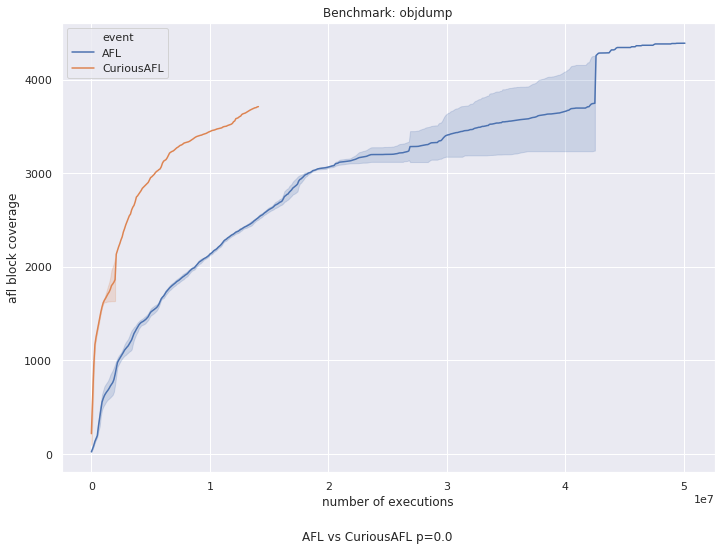

In [157]:
ax = sns.lineplot(x="running_exec_sum", y="cur_path", hue='event', ci=60, data=dffinal)
ax.set(xlabel='number of executions', ylabel='afl block coverage')

plt.legend()
plt.title('Benchmark: ' + exec_name)
plt.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./'+exec_name+'24h_covtime.png', dpi = 200)

## nm

In [163]:
exec_name = 'nm'
dffinal = pd.DataFrame()

In [164]:
for trial in ['1','2','3']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_afl' + str(trial))
    df = pd.read_csv(resultpath)
    df_helper = pd.DataFrame(np.array(range(df['# unix_time'][0], df['# unix_time'][len(df)-1]+1)))
    df_helper = df_helper.merge(df[['# unix_time', ' execs_per_sec', ' paths_total']], left_on=0, right_on='# unix_time', how='left', left_index=True)
    df_helper.set_index(0, inplace=True)
    del df_helper['# unix_time']
    df_helper[' execs_per_sec'].ffill(inplace=True)
    df_helper['running_exec_sum'] = df_helper[' execs_per_sec'].cumsum()
    df_helper = df_helper[[' paths_total', 'running_exec_sum']]
    
    df_helper['running_exec_sum'] = pd.to_datetime(df_helper['running_exec_sum'], unit='s', origin='unix')
    df = df_helper.set_index('running_exec_sum').resample('100000s').mean().reset_index()
    df['running_exec_sum'] = df.running_exec_sum.astype(int) / 10**9
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    #df = df.rename(columns={' paths_total': 'cur_path'})
    #del df['running_exec_sum']
    df['event'] = 'AFL'
    dffinal = dffinal.append(df)

In [165]:
# curious
resultpath = os.path.join(resultspath + exec_name, exec_name + '_curious2')
df = pd.read_csv(resultpath)
df_helper = pd.DataFrame(np.array(range(df['# unix_time'][0], df['# unix_time'][len(df)-1]+1)))
df_helper = df_helper.merge(df[['# unix_time', ' execs_per_sec', ' paths_total']], left_on=0, right_on='# unix_time', how='left', left_index=True)
df_helper.set_index(0, inplace=True)
del df_helper['# unix_time']
df_helper[' execs_per_sec'].ffill(inplace=True)
df_helper['running_exec_sum'] = df_helper[' execs_per_sec'].cumsum()
df_helper = df_helper[[' paths_total', 'running_exec_sum']]

df_helper['running_exec_sum'] = pd.to_datetime(df_helper['running_exec_sum'], unit='s', origin='unix')
df = df_helper.set_index('running_exec_sum').resample('100000s').mean().reset_index()
df['running_exec_sum'] = df.running_exec_sum.astype(int) / 10**9
df = df.rename(columns={' paths_total': 'cur_path'})
df['cur_path'] =df['cur_path'].ffill()
df['event'] = 'CuriousAFL'
dffinal = dffinal.append(df)


In [166]:
p = utest(dffinal, x_var='running_exec_sum')

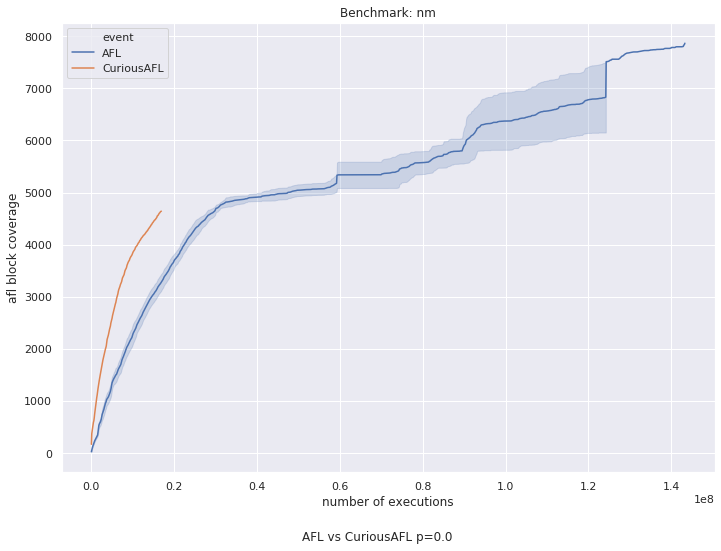

In [167]:
ax = sns.lineplot(x="running_exec_sum", y="cur_path", hue='event', ci=60, data=dffinal)
ax.set(xlabel='number of executions', ylabel='afl block coverage')

plt.legend()
plt.title('Benchmark: ' + exec_name)
plt.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./'+exec_name+'24h_covtime.png', dpi = 200)